**Importing modules**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


**Creating the NN object**

In [ ]:
layer_sizes = [784, 512, 256, 10]

# Define a simple neural network model
class Net(nn.Module):
    """" 
    This is a class Neural network implemented in pytorch. 
    It inherits from nn.Module and thereby makes sure that fancy functionalities 
    of Pytorch will be available for your neural network architecture. 
    """
    def __init__(self):
        super(Net, self).__init__()
        # Define your layers. Usually one defines linear layers and uses the relu function around these layers. 
        # A Linear layer is define via lin = nn.Linear(input_dim, output_dim)
        self.layers = nn.Sequential(
            nn.Linear(layer_sizes[0], layer_sizes[1]),
            nn.ReLU(),
            nn.Linear(layer_sizes[1], layer_sizes[2]),
            nn.ReLU(),
            nn.Linear(layer_sizes[2], layer_sizes[3])
        )

    def forward(self, x):
        # Define your evaluate function. You can use the pytorch relu function via torch.relu
        # You can call your linear layer at a given input x via self.lin(x)
        x = x.view(-1, 28 * 28)  # Flatten the input such that we have a vector
        x = self.layers(x)  # Pass through the defined layers
        return x

# Initialize the neural network model
net = Net()

**Network training**

In [ ]:
# Everything below this line is not relevant for you. It is used to download the dataset and train the neural network.

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Define data transformations and load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop

for epoch in range(1):  # You can adjust the number of epochs
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Mini-Batch {i + 1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print("Training finished")

# Save the trained model
torch.save(net.state_dict(), 'mnist_model.pth')

**Get the images**

In [ ]:
cwd = Path.cwd()
data_dir = cwd.parent / 'data'

def get_mnist():
    return datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

def return_image(image_index, mnist_dataset):
    # Get the image and its corresponding label
    image, label = mnist_dataset[image_index]

    # Now, you have the image as a PyTorch tensor.
    # You can access its data as a matrix using .detach().numpy()
    image_matrix = image[0].detach().numpy()  # Grayscale image, so we select the first channel (index 0)

    return image_matrix.reshape(image_matrix.size), image_matrix, label

def read_from_file(name=data_dir / "image_19961.txt"):
        x = np.zeros(28 * 28)
        with open(name) as file:
                for i, line in enumerate(file):
                    # split and convert values to floats
                    x[i * 28 : (i+1)*28] = [float(value) for value in line.strip().split()]




**Running the network**

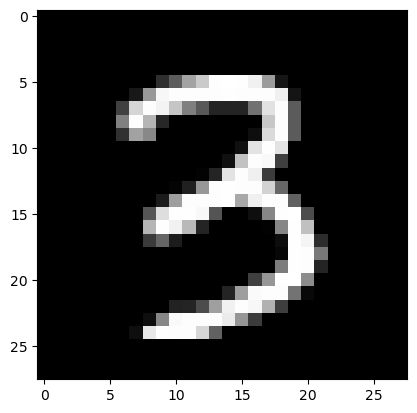

The response vector of the network is: 2
Image 27589 shows the number 3


In [40]:
# Choose an index to select one of the images
image_index = 27589
mnist_dataset = get_mnist()
x, image, label = return_image(image_index, mnist_dataset) # This here reads image {image_index} from the mnist dataset.
x_file = read_from_file() # In case you were not able to install torchvision, you can use this read_from_file function


response_vector = net.forward(torch.tensor(x)).detach().numpy()

plt.imshow(image, cmap='gray')
plt.show()

print(f"The response vector of the network is: {np.argmax(response_vector)}")
print(f"Image {image_index} shows the number {label}")